In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import scipy.cluster.hierarchy as sch
import time
import json
from numpy import where
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Carregamento de dados

In [6]:
dataframe_full = pd.read_csv('Placement_Data_Full_Class.csv')

In [7]:
dataframe_full.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


### Alocação em estrutura indexável (numpy array)

In [8]:
y_train = dataframe_full['status'].iloc[:].values
dataframe = dataframe_full.drop(['status', 'salary', 'sl_no', 'degree_t'], axis=1)
x_train = dataframe.iloc[:,:].values

### Plot dos dados em dimensão reduzida (2D)

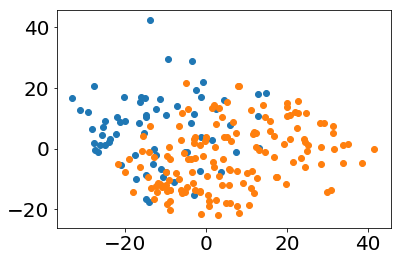

In [14]:
def plot_graph(x_, y_):
    pca = PCA(n_components=2)
    X, y = pca.fit_transform(x_), y_
    for class_value in range(2):
        row_ix = where(y == class_value)
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    plt.show()

plot_graph(x_train, y_train)

### Encoding dos dados não-numéricos

In [10]:
labelencoder_x = LabelEncoder()
labelencoder_y = LabelEncoder()

for i in range(len(x_train[0])):
    if type(x_train[0][i]) == str:
        x_train[:, i] = labelencoder_x.fit_transform(x_train[:, i])
        
y_train = labelencoder_y.fit_transform(y_train)

### Plot de Dendograma, Balanceamento e Matriz de Correlação

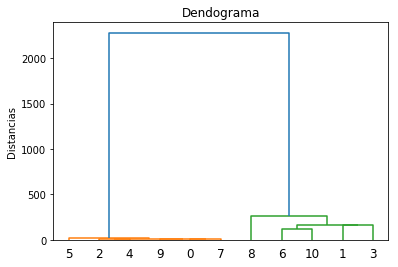

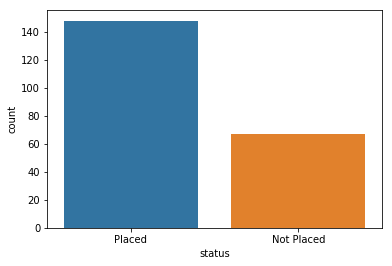



Matriz Correlações



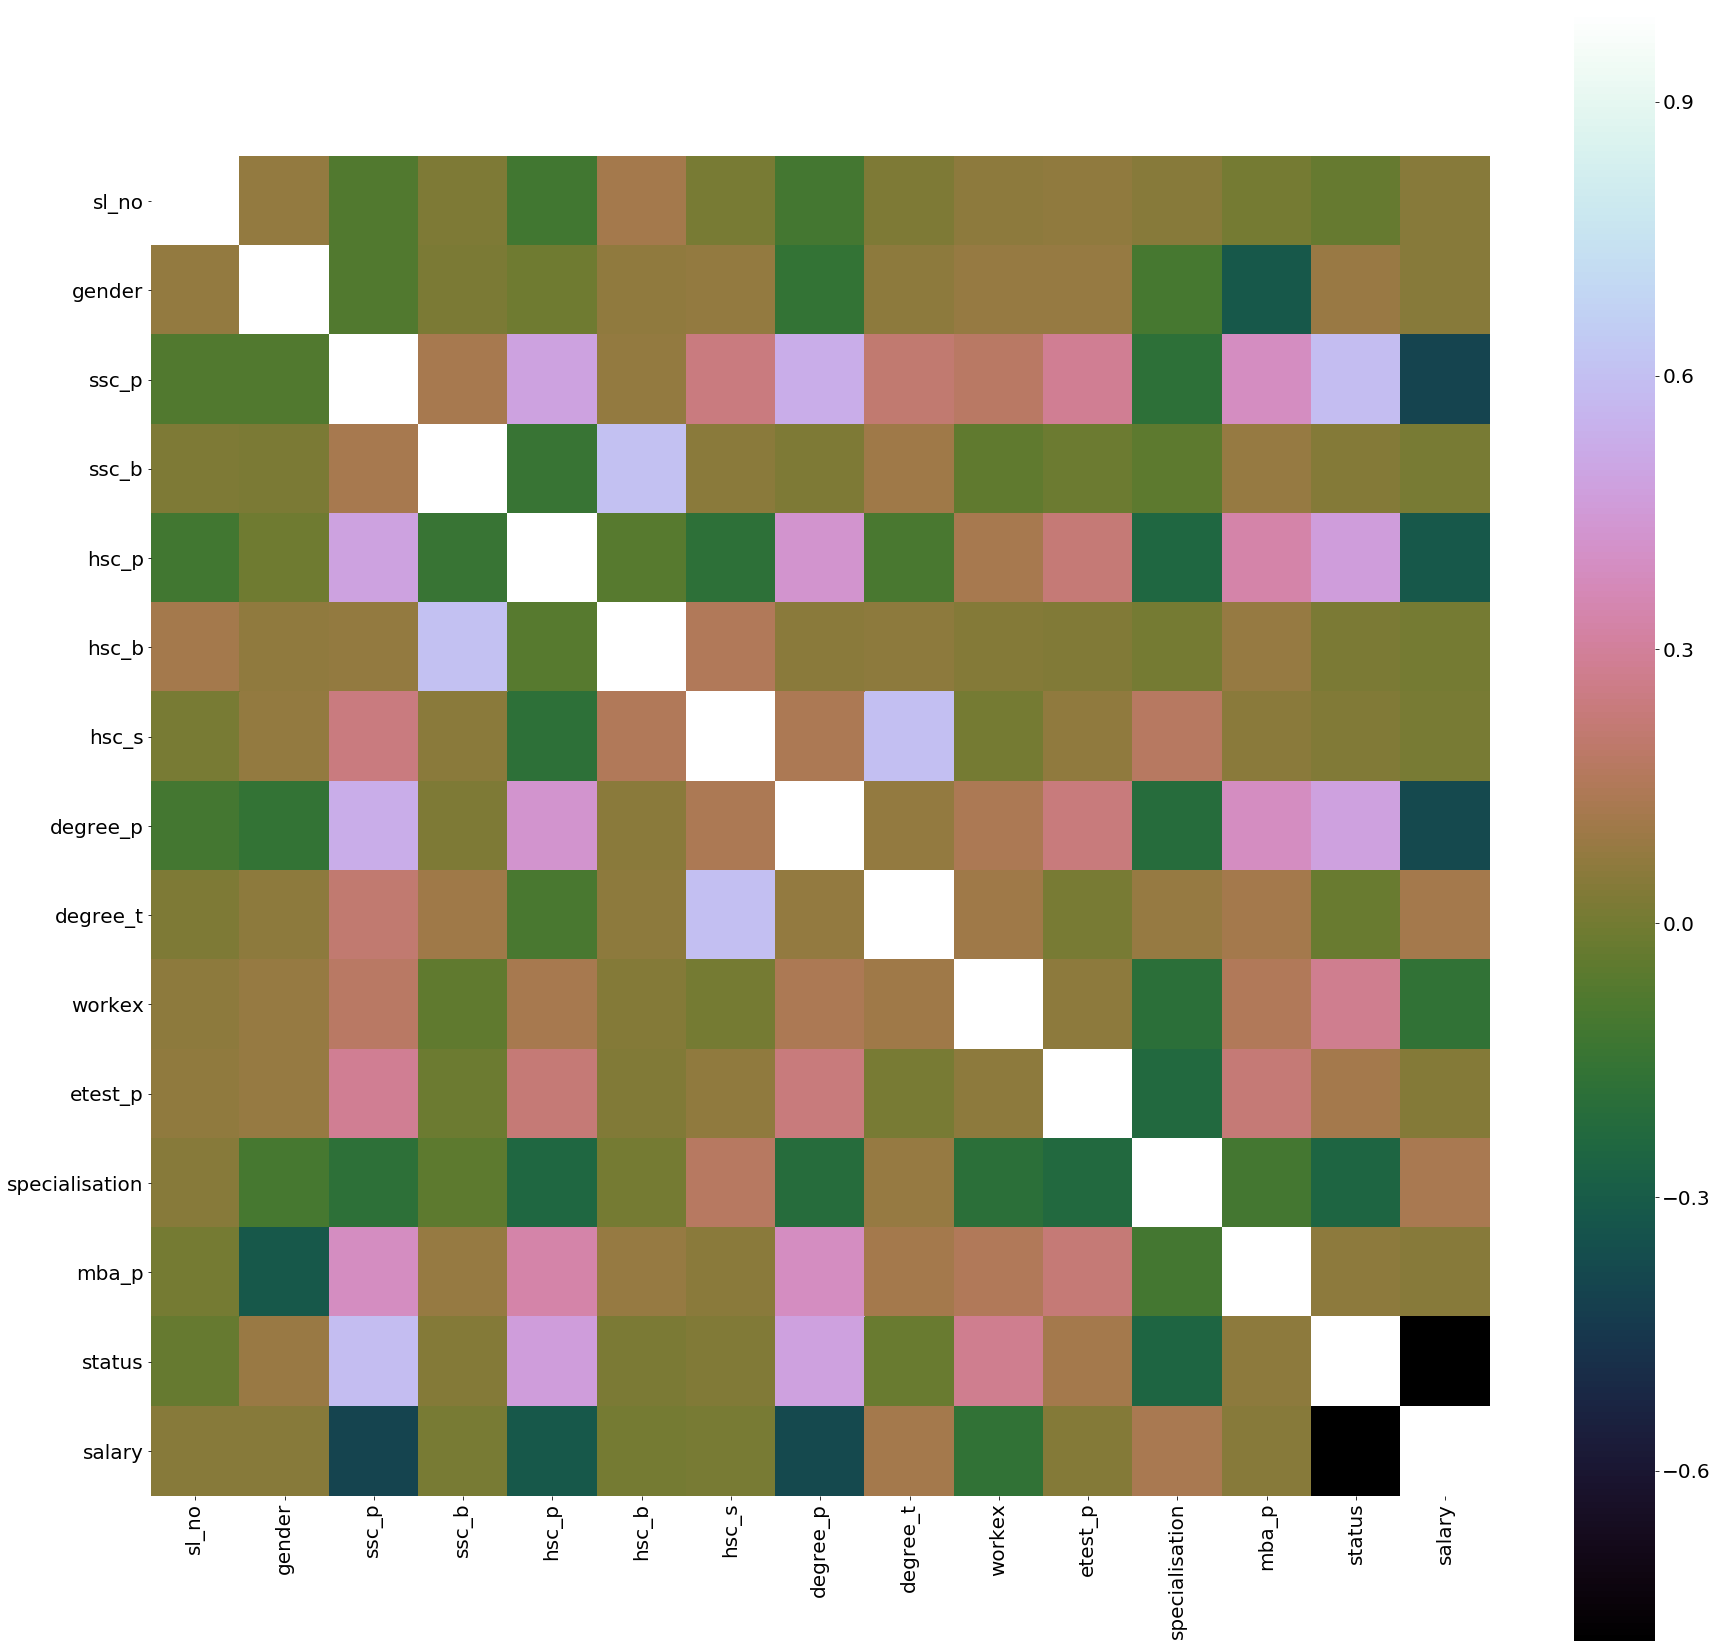

In [13]:
x_transposed = x_train.transpose()

dendogram = sch.dendrogram(sch.linkage(x_transposed, method = 'ward'))
plt.title("Dendograma")
plt.ylabel("Distancias")
plt.show()

sns.countplot(dataframe_full['status'], label = "Quantidade")
plt.show()

for column in dataframe_full.columns:
    if column != 'Label':
        dataframe_full[column] = labelencoder_x.fit_transform(dataframe_full[column])

print("\n\nMatriz Correlações\n")

corr_mat=dataframe_full.corr(method='pearson')
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(30,30))
sns.heatmap(corr_mat,vmax=1,square=True,cmap='cubehelix')
plt.show()

### Separação de dados de treino e dados de teste

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.20, random_state = 0)

### Criação do classificador utilizando algorítmo Random Forest (Grid Search)

In [18]:
classifier_optimized = RandomForestClassifier(criterion='gini', max_depth=None, max_features=6, min_samples_leaf=5, min_samples_split=2, n_estimators=23)

### Função de avaliação do classificador

In [19]:
def classification(classifier, x_train, x_test, y_train, y_test, X, y):

	menor = 0.0
	maior = 1.0
	#Cross-Validation
	print("Executando Cross-Validation...")
	scores = cross_val_score(classifier, X, y, cv=5)
	for i in range(len(scores)):
	    print("Cross-Validation Score : %s" % "{0:.3%}".format(scores[i]))
	    if (menor < scores[i]):
	    	menor = scores[i]
	    if (maior > scores[i]):
	    	maior = scores[i]
    
	print("\nIntervalo de confiança : " + str((menor-maior)*100) + "%\n")
	print("Cross-Validation Mean Score : %s" % "{0:.3%}\n".format(np.mean(scores)))
    
	print("Testando média do f1 score com cross validation.")
	scores_f1 = cross_val_score(classifier, X, y, cv=5, scoring="f1")
	for i in range(len(scores_f1)):
	    print("Cross-Validation Score: " + str(scores_f1[i]))
        
	print("\nF1_score mean: " + str(scores_f1.mean()))
    
	print("\nTreinando classificador com todos os dados de treino [sem cross validation]...")
	classifier.fit(x_train, y_train)  
	#teste de predição
	y_pred = classifier.predict(x_test)
	        
	print("Gerando matriz de confusão...")
	#matriz de confusão
	from sklearn.metrics import confusion_matrix
	cm = confusion_matrix(y_test, y_pred)

	print("\nInformacoes da classificacao:")
	accuracy = (cm[0,0] + cm[1,1])/len(y_test)
	FP = cm[1,0]
	FN = cm[0,1]
	print("Accuracy:")
	print(accuracy)
	stream = "Falso Negativo: " + str(FP) + " - Falso Positivo: " + str(FN)
	print(stream)
	print("F1_Score: ")
	print(f1_score(y_test, y_pred))
	print("Matriz de confusao:")
	print(cm)

In [20]:
classification(classifier_optimized, X_train, X_test, Y_train, Y_test, x_train, y_train)

Executando Cross-Validation...
Cross-Validation Score : 90.698%
Cross-Validation Score : 81.395%
Cross-Validation Score : 90.698%
Cross-Validation Score : 83.721%
Cross-Validation Score : 81.395%

Intervalo de confiança : 9.302325581395344%

Cross-Validation Mean Score : 85.581%

Testando média do f1 score com cross validation.
Cross-Validation Score: 0.9206349206349207
Cross-Validation Score: 0.8307692307692307
Cross-Validation Score: 0.9523809523809523
Cross-Validation Score: 0.8852459016393444
Cross-Validation Score: 0.8275862068965517

F1_score mean: 0.8833234424642

Treinando classificador com todos os dados de treino [sem cross validation]...
Gerando matriz de confusão...

Informacoes da classificacao:
Accuracy:
0.6976744186046512
Falso Negativo: 4 - Falso Positivo: 9
F1_Score: 
0.7796610169491525
Matriz de confusao:
[[ 7  9]
 [ 4 23]]
